# Important Considerations

## Overview

**Questions**
- What else should I be aware of?

**Objectives**
- Understand the different MD ensembles possible
- Become familiar with the cut-off and periodic boundary condition as a method to speed up MD simulation
- Understand how to implement such simplifications in the MD

Molecular dynamics (MD) is a powerful simulation technique in it's own right. 
However, in order to apply MD to practical simulations (e.g. of **real** systems), some other things should be considered must be made.

## Ensembles

The molecular dynamics algorithm outlined in the previous lesson makes use of the NVE ensemble (also known as the microcanonical ensemble), where the number of particles (N), volume of the system (V), and energy of the system (E) are all **kept constant**. 
This is not the only, or the most accurate, ensemble that exists, there is also other such as:
- NVT (canonical): number of particles (N), volume of system (V), temperature of the simulation (T)
- NPT (isothermal-isobaric): number of particles (N), pressure of system (P), temperature of the simulation (T)

For both the canonical and isothermal-isobaric ensembles, it is necessary to determine a method to **modulate the temperature** of the system. 
The temperature can be modulated using a variety of methods known as thermostating. 
The simplest, although one of the least accruate, is velocity rescaling. 
This is where the velocities of the individual particles are changed such that the kinetic energy of the total system more accurately matches that necessary for the desired temperature. 
For this the instaneous temperature of the system, $T_{\text{inst}}$, is defined as, 

$$ T_{\text{inst}} = \frac{\sum^N_{i=0}{m_i v_i^2}}{2Nk_B}, $$

where, $N$ is the number of particles, $m_i$ is the mass of particle $i$, $v_i$ is the velocity of particle $i$, and $k_B$ is the Boltzmann constant. 
This means that the velocities of the particles may be rescaled by the following relation, 

$$ \mathbf{v}_i = \mathbf{v}_i \sqrt{\dfrac{T_{\text{target}}}{\bar{T}}}, $$

where $\mathbf{v}_i$ is the velocity of particle $i$, $T_{\text{target}}$ is the target temperature for the themostat, and $\bar{T}$ is the average simulation temperature. 
pylj [1], to software that you shall use in the next lesson uses this method for producing an NVT simulation, using the `heat_bath` function. 
Various **other methods** for thermostating exist, such as the Anderson, Nosé-Hoover, or the Berendsen [2-5]. 

In order to achieve the NPT ensemble, it is necessary to use a **barostat** in addition to a thermostat. 
These allow the volume of the system to vary such that the pressure is constant throughout the simulation.
We will not discuss barostats any further, but there is plenty of information in more detailed texts. 

## Cut-offs

If we plot the Lennard-Jones potential all the way out to 15 Å, it will look something like this.

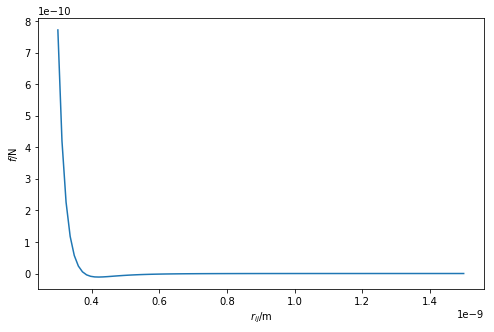

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def lj_force(rij, a, b):
    """
    Implementation of the Lennard-Jones potential 
    to calculate the force of the interaction.
    
    Parameters
    ----------
    rij: float
        Distance between particles i and j
    a: float 
        A parameter for interaction between i and j
    b: float 
        B parameter for interaction between i and j
    
    Returns
    -------
    float
        Force of the interaction between i and j.
    """
    return 12 * a / np.power(rij, 13) - 6 * b / np.power(rij, 7)

r = np.linspace(3e-10, 15e-10, 100)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(r, lj_force(r, 1.363e-134, 9.273e-78))
ax.set_xlabel(r'$r_{ij}$/m')
ax.set_ylabel(r'$f$/N')
plt.show()

It is clear that as the particles move further away from each other, the force between them **tends towards zero**. 
The concept of a cut-off suggests that if two particles are found to be very far apart, there is **no need** to calculate thh energy/force. 
Instead the value is simply taken as 0,

$$       f(r_{ij})=\left\{
  \begin{array}{@{}ll@{}}
    \dfrac{12A}{r_{ij}^{13}} - \dfrac{6B}{r_{ij}^7}, & \text{if}\ a<15\text{ Å} \\
    0, & \text{otherwise.}
  \end{array}\right.
$$

In addition to saving some computational cost, this provides a **more** realistic simulation. 
Furthermore, when there are periodic boundaries present (mentioned below), the cut-off ensures that the forces are not sampled incorrectly by having a cut-off of less than half of the cell size.  

This Python code below shows a modification of the Lennard-Jones potential that accounts for this cut-off.

In [2]:
cutoff = 15e-10

def lj_force_cutoff(rij, a, b):
    """
    Implementation of the Lennard-Jones potential 
    to calculate the force of the interaction which 
    is considerate of the cut-off.
    
    Parameters
    ----------
    rij: float
        Distance between particles i and j
    a: float 
        A parameter for interaction between i and j
    b: float 
        B parameter for interaction between i and j
    
    Returns
    -------
    float
        Force of the interaction between i and j.
    """
    if rij < cutoff:
        return 12 * a / np.power(rij, 13) - 6 * b / np.power(rij, 7)
    else:
        return 0

## Periodic boundary conditions

Even with cut-offs, it is still not possible to simulate a *realistic* system. 
This would require many more atoms than are possible on current computers.
An example of a very large molecular dynamics simulation is ~3 million atoms [6]. 
However, this is still only 1.8×10<sup>-16</sup> moles, which is **nowhere near** a realistic amount of substance.

The use of **periodic boundary conditions** (PBCs) creates an infinite pseudo-crystal of the simulation cell, arranged in a lattice. 
This allows for more realistic simulations as the system is able to interact through the cell walls with the adjacent cell. 
Figure 1 shows a pictorial example of a PBC. 

<center>
    <br>
    <img src="../images/pbc.png" width="300px">
    <i>Figure 1. A two-dimensional example of a periodic cell.</i>
    <br>
</center>

When a particle reaches the cell wall it moves into the adjecent cell, and since all the cells are identical, it appears on the other side. 
The code below modifies the `update_pos` and `get_acceleration` functions from the previous lesson to account for the periodic boundary condition.

In [3]:
mass_of_argon = 39.948 # amu
mass_of_argon_kg = mass_of_argon * 1.6605e-27

def update_pos(x, v, a, dt, box_length):
    """
    Update the particle positions accounting for the 
    periodic boundary condition.
    
    Parameters
    ----------
    x: ndarray of floats
        The positions of the particles in a single dimension
    v: ndarray of floats
        The velocities of the particles in a single dimension
    a: ndarray of floats
        The accelerations of the particles in a single dimension
    dt: float
        The timestep length
    box_length: float 
        The size of the periodic cell
    
    Returns
    -------
    ndarray of floats:
        New positions of the particles in a single dimension
    """
    new_pos = x + v * dt + 0.5 * a * dt * dt
    new_pos = new_pos % box_length
    return new_pos

def get_accelerations(positions, box_length, cutoff):
    """
    Calculate the acceleration on each particle as a 
    result of each other particle. 
    
    Parameters
    ----------
    positions: ndarray of floats
        The positions, in a single dimension, for all
        of the particles
    box_length: float 
        The size of the periodic cell
    cutoff: float
        The distance after which the interaction 
        is ignored
        
    Returns
    -------
    ndarray of floats
        The acceleration on each particle
    """
    accel_x = np.zeros((positions.size, positions.size))
    for i in range(0, positions.size - 1):
        for j in range(i + 1, positions.size):
            r_x = positions[j] - positions[i]
            rmag = np.sqrt(r_x * r_x)
            force_scalar = lj_force(rmag, 1.363e-134, 9.273e-78)
            force_x = force_scalar * r_x / rmag
            accel_x[i, j] = force_x / mass_of_argon_kg
            accel_x[j, i] = - force_x / mass_of_argon_kg
    return np.sum(accel_x, axis=0)

This means that we can use these new functions in our molecular dynamics simulation built previously. 

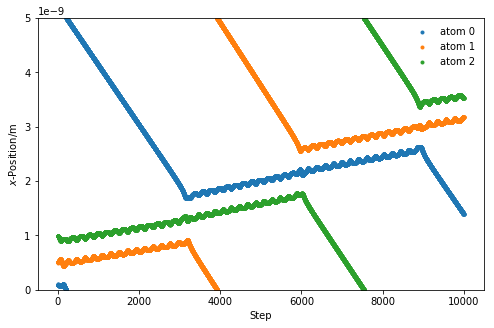

In [5]:
from scipy.constants import Boltzmann

def update_velo(v, a, a1, dt):
    """
    Update the particle velocities.
    
    Parameters
    ----------
    v: ndarray of floats
        The velocities of the particles in a single dimension
    a: ndarray of floats
        The accelerations of the particles in a single dimension 
        at the previous timestep
    a1: ndarray of floats
        The accelerations of the particles in a single dimension
        at the current timestep
    dt: float
        The timestep length
    
    Returns
    -------
    ndarray of floats:
        New velocities of the particles in a single dimension
    """
    return v + 0.5 * (a + a1) * dt

def init_velocity(T, number_of_particles):
    """
    Initialise the velocities for a series of particles.
    
    Parameters
    ----------
    T: float
        Temperature of the system at initialisation
    number_of_particles: int
        Number of particles in the system
    
    Returns
    -------
    ndarray of floats
        Initial velocities for a series of particles
    """
    R = np.random.rand(number_of_particles) - 0.5
    return R * np.sqrt(Boltzmann * T / mass_of_argon_kg)

def run_md(dt, number_of_steps, initial_temp, x, box_length):
    """
    Run a MD simulation.
    
    Parameters
    ----------
    dt: float
        The timestep length
    number_of_steps: int
        Number of iterations in the simulation
    initial_temp: float
        Temperature of the system at initialisation
    x: ndarray of floats
        The initial positions of the particles in a single dimension
    box_length: float 
        The size of the periodic cell
        
    Returns
    -------
    ndarray of floats
        The positions for all of the particles throughout the simulation
    """
    cutoff = box_length / 2.
    positions = np.zeros((number_of_steps, 3))
    v = init_velocity(initial_temp, 3)
    a = get_accelerations(x, box_length, cutoff)
    for i in range(number_of_steps):
        x = update_pos(x, v, a, dt, box_length)
        a1 = get_accelerations(x, box_length, cutoff)
        v = update_velo(v, a, a1, dt)
        a = np.array(a1)
        positions[i, :] = x
    return positions

box_length = 5e-9
sim_pos = run_md(1e-14, 10000, 300, np.array([1e-10, 5e-10, 1e-9]), box_length)
    
%matplotlib inline
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
for i in range(sim_pos.shape[1]):
    ax.plot(sim_pos[:, i], '.', label='atom {}'.format(i))
ax.set_ylim(0, box_length)
ax.set_xlabel(r'Step')
ax.set_ylabel(r'$x$-Position/m')
ax.legend(frameon=False)
plt.show()

## Key Points
- Note that there are simplifications that are possible for MD simulations
- The cut-off reduces the number of interactions for which the energy/force must be determined
- The periodic boundary condition creates a pseudo-crystal of the cell being simulated

# References

1. McCluskey, A. R., Morgan, B. J., Edler, K. J., & Parker, S. C. (2018). *JOSE*, **1**, 19, [10.21105/jose.00019](https://doi.org/10.21105/jose.00019)
2. Andersen, H. C. (1980). J. Chem. Phys., **72**, 2384, [10.1063/1.439486](https://doi.org/10.1063/1.439486)
3. Nosé, S. (1984). J. Chem. Phys., **81**, 511-519, [10.1063/1.447334](https://doi.org/10.1063/1.447334).
4. Hoover, W. G. (1985). Phys. Rev. A., **31**, 1695-1697, [10.1103/PhysRevA.31.1695](https://doi.org/10.1103/PhysRevA.31.1695)
5. Berendsen, H. J. C., Postma, J. P. M., van Gunsteren, W. F., DiNola, A., & Haak, J. R. (1984). J. Chem. Phys., **81**, 3684-3690, [10.1063/1.448118](https://doi.org/10.1063/1.448118).
6. Gumbart, J., Trabuco, L. G., Schreiner, E., Villa, E., and Schulten, K. (2009). Structure, **17**, 1453-1464, [10.1016/j.str.2009.09.010](https://doi.org/10.1016/j.str.2009.09.010)